In [1]:
from collections import defaultdict
import random
import numpy as np
import string
from sklearn import svm
import math
from statistics import mean 
from scipy import spatial
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime

In [29]:
data = pd.read_csv("gun-violence-data.csv")

In [3]:
# find distribution of injury
import matplotlib.pyplot as plt
victims = pd.DataFrame(list(data['n_killed'] + data['n_injured']), columns = ['people at a time'])
victims.hist(bins = range(10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a08811b00>]],
      dtype=object)

In [29]:
# total number of datas
list(data.columns.values)

['incident_id',
 'date',
 'state',
 'city_or_county',
 'address',
 'n_killed',
 'n_injured',
 'incident_url',
 'source_url',
 'incident_url_fields_missing',
 'congressional_district',
 'gun_stolen',
 'gun_type',
 'incident_characteristics',
 'latitude',
 'location_description',
 'longitude',
 'n_guns_involved',
 'notes',
 'participant_age',
 'participant_age_group',
 'participant_gender',
 'participant_name',
 'participant_relationship',
 'participant_status',
 'participant_type',
 'sources',
 'state_house_district',
 'state_senate_district']

In [6]:
# find most crime cities or counties according to the injury count
# find most crime states
crime_cities = defaultdict(int)
crime_states = defaultdict(int)
for crime in data.iterrows():
    crime_cities[crime[1]['city_or_county']] += 1 + crime[1]['n_killed'] + crime[1]['n_injured']
    crime_states[crime[1]['state']] += 1 + crime[1]['n_killed'] + crime[1]['n_injured']

In [27]:
# get the most crime states
CrimCities = [(crime_cities[x], x) for x in crime_cities]
CrimCities.sort()
CrimCities.reverse()

In [9]:
# get the most crime states
CrimState = [(crime_states[x], x) for x in crime_states]
CrimState.sort()
CrimState.reverse()

sumCrimes = 0
for (count, state) in CrimState:
    sumCrimes += count

# get 40 percentile of the crimes
mostCrimeState = set()
i = 0
for (count, state) in CrimState:
    i += count
    mostCrimeState.add(state)
    
    if(i > (sumCrimes * 4) // 10):
        break

In [10]:
def feature(data):
    # append features
    feat = np.zeros(48)
        
    # append date
    date = data['date']
    yr = int(date[:4])
    mn = int(date[5:7])
    dy = int(date[8:9])
    feat[0] = yr
    feat[mn] = 1
    feat[12 + dy] = 1
    
    # GPS
    feat[44] = data['latitude']
    feat[45] = data['longitude']
    
    # in the most crime state
#     feat[46] = data['state'] in mostCrimeState 
    
    # bias
    feat[47] = 1
    
    return feat

In [35]:
# !pip install opencage
# from opencage.geocoder import OpenCageGeocode
# from pprint import pprint

# key = '7395fc93ec5746ea8b0401b4d6b4d1d8'
# geocoder = OpenCageGeocode(key)

def pat_negative_dat(data):
    # random generate lat, long, and date for negative data
    
    # select important data
    data = data[['date','n_killed','n_injured','latitude','longitude','city_or_county']]
    data.drop_duplicates(inplace= True)
    data.dropna(inplace= True)

    lats = set(data['latitude'])
    lat_range = (min(lats), max(lats))
    longs = set(data['longitude'])
    long_range = (min(longs), max(longs))
    dates = set([datetime.strptime(d, '%Y-%m-%d').timestamp() for d in data['date']])
    date_range = (min(dates), max(dates))

    # for faster random generating (add GPS to date)
    date_info = defaultdict(list)
    for line in data.iterrows():
        date_info[line[1]['date']].append((line[1]['latitude'],line[1]['longitude']))

    dat = set()

    # Generating data with no gun violence to achieve data balance
    while len(dat) < len(data):
        randLat = random.uniform(lat_range[0],lat_range[1])
        randLong = random.uniform(lat_range[0],lat_range[1])
        randDate = datetime.utcfromtimestamp(random.uniform(date_range[0],date_range[1])).strftime('%Y-%m-%d')

        # whether add it to data
        add = True
        if (randDate in date_info):
            for gps in date_info[randDate]:
                # check if data contains the random generated location 
                if (abs(randLat - gps[0])+abs(randLong - gps[1]) < 0.5):
                    add = False
                    break                
        if (add):
            # get it's city name
#             results = geocoder.reverse_geocode(44.8303087, -0.5761911)
#             pprint(results[0]['components']['city'])
            dat.add((randDate,0,0,randLat,randLong,'?'))

            if (len(dat)%100000 == 0):
                print(len(dat))

    # check the randomly generated file with output = false 
    falsedf = pd.DataFrame(list(dat),columns=['date','n_killed','n_injured','latitude','longitude','city_or_county'])
    falsedf.drop_duplicates(inplace= True)
    
    # add label to original data violent =  true
    data['violent'] = pd.Series(np.ones(len(data)), index=data.index)
    # add label to generated data violent =  false
    falsedf['violent'] = pd.Series(np.zeros(len(data)), index=falsedf.index)

    # combine dataframes, shuffle, reset index
    data = data.append(falsedf).sample(frac=1).reset_index(drop=True)
    # convert violent to boolean
    data['violent'] = data['violent'].astype('bool')

    print("Done")
    return data

In [55]:
# train model

In [56]:
def pad_nagative_data(data):
    # takes a dataframe and returns a dataframe that has balanced targets

    # select important data
    data = data[['state','date','n_killed','n_injured','latitude','longitude']]
    data.drop_duplicates(inplace= True)
    data.dropna(inplace= True)

    # encode state
    state_encode = {}
    state_decode = {}
    for i, state in enumerate(set(data['state'])):
        state_decode[i] = state
        state_encode[state] = i

    # for faster random generating 
    state_info = {}
    for i in state_decode:
        state_info[i] = data.loc[data['state'] == state]

    dat = set()

    # find available dates
    dates = set(data['date'])

    # find how many data with an target = False needed
    i = len(data)
    
    # Generating data with no gun violence to achieve data balance
    while len(dat) < len(data):
        # random generate state
        state_num = random.randint(0,50)

        # random generate date
        date = random.sample(dates,1)[0]

        # random generate latitude and longitude
        lat =  state_info[state_num]['latitude'].sample(n=1).iloc[0]
        longi = state_info[state_num]['longitude'].sample(n=1).iloc[0]

        add = False
        # add it to data
        if (date not in state_info[state_num]['date']):
            add = True
        else:
            df = state_info[state_num]
            df = df[df['date']==date]
            if (lat not in df['latitude']):
                add = True
            else:
                df = df[df['latitude']==lat]
                if (longi not in df['longitude']):
                    add = True
                else:
                    continue

        if (add):
            dat.add((state_decode[state_num],date,0,0,lat,longi))
            i -= 1    
            if (i%100000 == 0):
                print(i)

    # check the randomly generated file with output = false 
    falsedf = pd.DataFrame(list(dat),columns=['state','date','n_killed','n_injured','latitude','longitude'])
    falsedf.drop_duplicates(inplace= True)

    # make sure there is no over lapping
    if (len(pd.merge(data, falsedf, how='inner')) != 0):
        print("Error")

    # make sure there's same number of new data 
    if (len(falsedf) != len(data)):
        print("Error2")

    # add label to original data violent =  true
    data['violent'] = pd.Series(np.ones(len(data)), index=data.index)
    # add label to generated data violent =  false
    falsedf['violent'] = pd.Series(np.zeros(len(data)), index=falsedf.index)
    
    # combine dataframes
    data = data.append(falsedf)
    # shuffle dataframe
    data = data.sample(frac=1).reset_index(drop=True)
    data['violent'] = data['violent'].astype('bool')
    # clean memory
    del falsedf, state_decode, state_encode, state_info
    
    print("Done")
    return data

In [273]:
import requests
url = 'https://maps.googleapis.com/maps/api/geocode/json'
params = {'sensor': 'false', 'lat': 37.3860517, 'lng':-122.0838511}
r = requests.get(url, params=params)
results = r.json()['results']


In [294]:
g = geocoder.google([32.8328, 90.2713], method='reverse')

'Bordeaux'


In [320]:
l = reverse_geocode_result[0]

In [321]:
l.keys()

dict_keys(['address_components', 'formatted_address', 'geometry', 'place_id', 'types'])

In [323]:
l['address_components']

[{'long_name': '655785', 'short_name': '655785', 'types': ['postal_code']},
 {'long_name': 'Republic of Khakassia',
  'short_name': 'Republic of Khakassia',
  'types': ['administrative_area_level_1', 'political']},
 {'long_name': 'Russia',
  'short_name': 'RU',
  'types': ['country', 'political']}]

In [36]:
data = pat_negative_dat(data)
print(len(data))

/Users/YangLiu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/YangLiu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


100000
200000


/Users/YangLiu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Done
461018


In [38]:
# train_data = data[:len(data)*8//10]
# valid_data = data[len(data)*8//10:]
train_data = data.loc[:50000]
valid_data = data.loc[50000:100000]

In [14]:
valid_data

,date,n_killed,n_injured,latitude,longitude,violent
20000,2016-10-19,0,0,45.554700,-122.530000,True
20001,2016-05-11,0,0,63.655888,62.944318,False
20002,2014-11-01,0,0,32.262900,-90.304500,True
20003,2014-09-13,0,0,37.680313,44.093049,False
20004,2017-02-24,0,0,27.191600,-80.245700,True
20005,2014-10-24,0,0,69.037811,56.497656,False
20006,2013-04-02,0,0,61.553086,36.600481,False
20007,2017-04-24,0,1,34.726000,-92.369600,True
20008,2017-12-26,0,0,32.506900,-84.918100,True
20009,2016-10-21,1,0,36.119600,-115.173000,True


In [25]:
#baseline 
train_x = [[line[1]['longitude']] for line in train_data.iterrows()]
train_y = [line[1]['violent'] for line in train_data.iterrows()]
clf = 0

clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
clf.fit(train_x, train_y)
valid_x = [[line[1]['longitude']] for line in valid_data.iterrows()]
valid_y = [line[1]['violent'] for line in valid_data.iterrows()]
output = clf.predict(valid_x)
print("Model accuracy:" + str(sum(valid_y == output) / len(valid_y)))

Model accuracy:0.999980000399992


In [20]:
output

array([False, False, False, ...,  True, False, False])

In [166]:
train_x = [feature(line[1]) for line in train_data.iterrows()]
train_y = [line[1]['violent'] for line in train_data.iterrows()]

In [167]:
clf = svm.SVC(kernel='linear')
clf.fit(train_x, train_y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [174]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
clf.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [175]:
valid_x = [feature(line[1]) for line in valid_data.iterrows()]
valid_y = [line[1]['violent'] for line in valid_data.iterrows()]
output = clf.predict(valid_x)
print("Model accuracy:" + str(sum(valid_y == output) / len(valid_y)))

Model accuracy:0.999980000399992


In [219]:
data.dropna(inplace=True)
valid_x2 = [feature(line[1]) for line in data.loc[:50000].iterrows()]
valid_y2 = [1 for line in data.loc[:50000].iterrows()]
output = clf.predict(valid_x2)
print("Model accuracy:" + str(sum(valid_y2 == output) / len(valid_y2)))

Model accuracy:1.0


In [301]:
# lat = 32.8328 # input in range (19.1114, 71.3368)
# long = 90.2713 # in range (-171.429, 97.4331)
year = "2017"

month = "12"
if(len(month) == 1):
    month = "0" + month
            
day = "24"

date = str(year) + "-" + str(month) + "-" + str(day)
pairs = []
trues = 0
falses = 0

for long in list(np.linspace(-171, 0.1,97)):
    for lat in list(np.linspace(19, 0.1, 71)):
#         dates = []
#         for d in range(31):
#             d = str(i)
#             if(len(d) == 1):
#                 d = "0" + d
#             dates.append(year + "-" + month + "-" + d)
        
        # datetime.strptime(str(year) + "-" + str(month) + "-" + str(day), '%Y-%m-%d')
        inp = pd.DataFrame([[date,None,None,lat,long] for date in dates],columns=['date','n_killed','n_injured','latitude','longitude'])
        
        out = clf.predict([feature(inp.loc[0])])
        
#         for i in range(sum(out)):
        if (out[0]):
            trues += 1
            pairs.append((lat,long))
        else:
            falses += 1
        
#         print(clf.predict([feature(inp.iloc[0])])[0])     

In [302]:
import folium
from folium import plugins
import matplotlib.pyplot as plt
import seaborn as sns

heatmap = folium.Map([pairs[0][0], pairs[0][1]])
# placeArr = map_data[['latitude', 'longitude']].as_matrix()
placeArr = pairs#random.sample(pairs, 5000)
heatmap.add_children(plugins.HeatMap(placeArr, radius=15))
heatmap

/Users/YangLiu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  if __name__ == '__main__':


In [252]:
CrimCities

[(10814, 'Chicago'),
 (3943, 'Baltimore'),
 (3279, 'Washington'),
 (3071, 'New Orleans'),
 (2963, 'Philadelphia'),
 (2501, 'Saint Louis'),
 (2501, 'Houston'),
 (2487, 'Milwaukee'),
 (2448, 'Jacksonville'),
 (2386, 'Memphis'),
 (2252, 'Columbus'),
 (1920, 'Indianapolis'),
 (1834, 'Detroit'),
 (1784, 'Cleveland'),
 (1755, 'Springfield'),
 (1737, 'Boston'),
 (1628, 'San Antonio'),
 (1501, 'Oakland'),
 (1425, 'Louisville'),
 (1418, 'Brooklyn'),
 (1381, 'Kansas City'),
 (1367, 'Jackson'),
 (1358, 'Atlanta'),
 (1348, 'Las Vegas'),
 (1329, 'Nashville'),
 (1317, 'Richmond'),
 (1296, 'Wilmington'),
 (1291, 'Charlotte'),
 (1260, 'Tulsa'),
 (1179, 'Dallas'),
 (1114, 'Columbia'),
 (1108, 'Cincinnati'),
 (1066, 'Los Angeles'),
 (1065, 'Fresno'),
 (1036, 'Dayton'),
 (1020, 'Orlando'),
 (1007, 'Portland'),
 (978, 'Birmingham'),
 (973, 'Phoenix'),
 (967, 'Rochester'),
 (963, 'Buffalo'),
 (959, 'Peoria'),
 (945, 'Lexington'),
 (936, 'Pittsburgh'),
 (930, 'Little Rock'),
 (924, 'Omaha'),
 (877, 'Newark'

In [ ]:
# find most crime cities or counties according to the injury count
# find most crime states
crime_cities = defaultdict(int)
crime_states = defaultdict(int)
for crime in data.iterrows():
    crime_cities[crime[1]['city_or_county']] += 1 + crime[1]['n_killed'] + crime[1]['n_injured']
    crime_states[crime[1]['state']] += 1 + crime[1]['n_killed'] + crime[1]['n_injured']
# get the most crime cities or counties
CrimCities = [(crime_cities[x], x) for x in crime_cities]
CrimCities.sort()
CrimCities.reverse()

sumCrimes = 0
for (count, city) in CrimCities:
    sumCrimes += count

# get 40 percentile of the crimes
mostCrimeCities = set()
i = 0
for (count, city) in CrimCities:
    i += count
    mostCrimeCities.add(city)
    
    if(i > (sumCrimes * 4) // 10):
        break

In [16]:
# total number of cities
len(crime_count_city)

0

In [65]:
baseline_dict = []
count = 0
for (wc,w) in mostCrimArea:
    count += wc
    baseline_dict.append(w)
    if(count > len(data)//2): break

In [255]:
train_data = data[:20000]
valid_data = data[20000:40000]

In [335]:
data

,state,date,n_killed,n_injured,latitude,longitude,violent
0,Pennsylvania,2015-12-12,1,0,40.3499,-79.8337,True
1,New Jersey,2017-04-07,0,1,39.7279,-75.0708,True
2,Wisconsin,2017-07-14,0,1,43.1122,-87.9566,True
3,District of Columbia,2014-07-05,0,0,38.9073,-77.0467,True
4,Utah,2017-04-18,0,0,35.0930,-104.4840,False
5,California,2016-09-09,2,0,36.7625,-121.7540,True
6,Washington,2015-11-27,0,0,47.8622,-121.8170,True
7,Virginia,2016-07-10,0,1,37.5214,-77.4273,True
8,West Virginia,2014-05-30,0,0,35.0566,-105.5940,False
9,South Dakota,2017-06-23,0,0,35.5999,-106.6030,False


In [66]:
baseline_dict[:10]

['Chicago',
 'Baltimore',
 'New Orleans',
 'Philadelphia',
 'Washington',
 'Jacksonville',
 'Houston',
 'Milwaukee',
 'Saint Louis',
 'Memphis']

In [42]:
l = []
for i in range(1,10):
    baseline_dict = set()
    count = 0
    for (wc,w) in CrimCities:
        count += wc
        baseline_dict.add(w)
        if(count > (len(data) * i)//10): break
    ## test the baseline model
    acc = []
    for k,v in valid_data.iterrows():
        if(v['city_or_county'] in baseline_dict):
            if v['violent']:
                acc.append(1)
            else:
                acc.append(0)
        else:
            if v['violent']:
                acc.append(0)
            else:
                acc.append(1)
    l.append((i*10,sum(acc)/len(acc)))

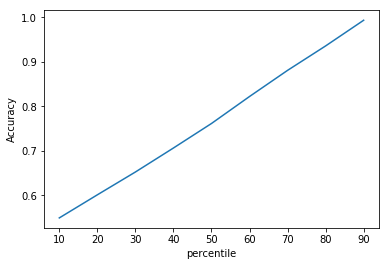

In [44]:
x,y = zip(*l)
plt.plot(x,y)
plt.ylabel('Accuracy')
plt.xlabel('percentile')
plt.show()

In [45]:
40, 50, 60
 0.7062658746825063,
  0.7613047739045219,
  0.8219235615287694,

((10, 20, 30, 40, 50, 60, 70, 80, 90),
 (0.5492890142197157,
  0.6011479770404592,
  0.6523669526609468,
  0.7062658746825063,
  0.7613047739045219,
  0.8219235615287694,
  0.880622387552249,
  0.9354812903741925,
  0.993160136797264))

In [68]:
cities = [i for i in crime_count_city]
pos_valid = []
neg_valid = []
for k,v in valid_data.iterrows():
    pos_valid.append((v['city_or_county'],1))
    neg_valid.append((random.choice(cities), 0))
valid = pos_valid+neg_valid    

In [ ]:
# accuracy on valid set
# acc = []
# for i,v in enumerate(valid):
#     if(v[0] in baseline_dict):
#         acc.append(1)
#     else:
#         acc.append(0)
# print(sum(acc)/len(acc))